In [1]:
from functions import *
from torchvision.transforms import InterpolationMode

# --- Configuration ---
class Config:
    data_dir = "./chest"
    backbone = "resnet18"
    version = 'chest_my'
    projection_dim = 128
    batch_size = 512
    simclr_epochs = 10
    learning_rate = 0.6
    weight_decay = 1e-6
    temperature = 0.5
    finetune_epochs = 10
    log_interval = 1

args = Config()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from torchvision.models import resnet18
import torch
from torch.optim import SGD
from torch.optim.lr_scheduler import LambdaLR, CosineAnnealingLR
from torchvision.models import resnet18
from torchvision import transforms
from torch.utils.data import DataLoader


train_transform = transforms.Compose([
    transforms.RandomResizedCrop(
        size=(224, 224),
        scale=(0.75, 1.0),
        ratio=(0.75, 1.0),
        interpolation=InterpolationMode.BICUBIC,
        antialias=True
    ),
    transforms.RandomApply(
        [transforms.ColorJitter(
            brightness=(0.9, 1.1),
            contrast=(0.9, 1.1),
            saturation=(0.9, 1.1),
            hue=(-0.1, 0.1)
        )],
        p=0.7  
    ),

    transforms.RandomHorizontalFlip(p=0.5),

    transforms.ToTensor(),
])


In [2]:

from medmnist import ChestMNIST, PneumoniaMNIST

# pneumoniamnist = GenericPairDataset(split='train', download=True, as_rgb=False, size=224)
chestmnist = ChestMNIST(split='train', download=True, as_rgb=False, size=224)
chest_pair = GenericPairDataset(chestmnist, transform=train_transform)
train_loader = DataLoader(chest_pair, batch_size=args.batch_size, shuffle=True)




Using downloaded and verified file: C:\Users\sever\.medmnist\chestmnist_224.npz


In [3]:
chestmnist[0]

(<PIL.Image.Image image mode=L size=224x224>,
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

In [4]:
base_encoder = resnet18
model = SimCLR(base_encoder, projection_dim=args.projection_dim).to(device)

optimizer = SGD(model.parameters(), lr=args.learning_rate, momentum=0.9, weight_decay=args.weight_decay)
scheduler = LambdaLR(optimizer, lr_lambda=lambda step: get_lr(step, args.simclr_epochs * len(train_loader), args.learning_rate, 1e-4))

train_loss_simclr = train_simclr(model, train_loader, optimizer, scheduler, device, args.simclr_epochs)
torch.save(model.state_dict(), f"./{args.version}.pt")

c:\Users\sever\OneDrive\Рабочий стол\Homework2\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sever\OneDrive\Рабочий стол\Homework2\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
100%|██████████| 154/154 [02:19<00:00,  1.10it/s]
INFO:functions:Epoch 1, Avg Loss: 5.6682
100%|██████████| 154/154 [02:26<00:00,  1.05it/s]
INFO:functions:Epoch 2, Avg Loss: 5.2668
100%|██████████| 154/154 [02:26<00:00,  1.05it/s]
INFO:functions:Epoch 3, Avg Loss: 5.1473
100%|██████████| 154/154 [02:24<00:00,  1.07it/s]
INFO:functions:Epoch 4, Avg Loss: 5.1044
100%|██████████| 154/154 [02:24<00:00,  1.06it/s]
INFO:functions:

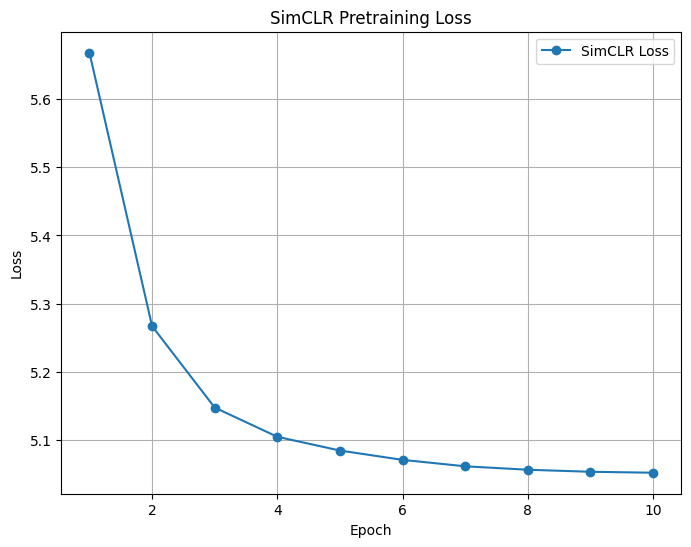

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(range(1, args.simclr_epochs + 1), train_loss_simclr, label="SimCLR Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("SimCLR Pretraining Loss")
plt.legend()
plt.grid(True)

plt.savefig(f'pretrain_{args.version}.jpg') 

plt.show()


In [6]:

# --- Dataset Preparation ---
from medmnist import ChestMNIST
test_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
])


train_set_multilabel = ChestMNIST(split='train', download=True, as_rgb=False, transform=train_transform, target_transform=lambda y: torch.tensor(y, dtype=torch.float32))
test_set_multilabel = ChestMNIST(split='test', download=True, as_rgb=False, transform=test_transform, target_transform=lambda y: torch.tensor(y, dtype=torch.float32))

train_loader_multilabel = DataLoader(train_set_multilabel, batch_size=args.batch_size, shuffle=True)
test_loader_multilabel = DataLoader(test_set_multilabel, batch_size=args.batch_size, shuffle=False)

# Freeze encoder parameters
for param in model.enc.parameters():
    param.requires_grad = False

# Instantiate linear model for multi-label classification
multi_label_model = MultiLabelLinModel(model.enc, model.feature_dim, n_classes=14).to(device)

# Optimizer and scheduler
optimizer = torch.optim.SGD(
    multi_label_model.parameters(),
    lr=0.2,
    momentum=0.9,
    weight_decay=1e-6,
    nesterov=True
)

scheduler = LambdaLR(
    optimizer,
    lr_lambda=lambda step: get_lr(
        step,
        args.finetune_epochs * len(train_loader_multilabel),
        args.learning_rate,
        1e-4
    )
)

# --- Training ---
class_weights = torch.tensor([1.0 / count for count in [7996, 1950, 9261, 13914, 3988, 4375, 978, 3705, 3263, 1690, 1799, 1158, 2279, 144]]).to(device)
class_weights /= class_weights.sum()  # Normalize weights

results = train_multilabel_probe(
    multi_label_model,
    train_loader_multilabel,
    test_loader_multilabel,
    optimizer,
    scheduler,
    device,
    args.finetune_epochs,
    class_weights
)

# Extract results
train_losses, test_losses, train_f1_micro, test_f1_micro, train_f1_macro, test_f1_macro = results


Using downloaded and verified file: C:\Users\sever\.medmnist\chestmnist.npz
Using downloaded and verified file: C:\Users\sever\.medmnist\chestmnist.npz


Epoch 1/10 - Testing: 100%|██████████| 44/44 [00:01<00:00, 31.12it/s]
INFO:functions:Epoch 1/10: Train Loss=0.0060, Test Loss=0.0049, Train Micro F1=0.0595, Test Micro F1=0.0000, Train Macro F1=0.0297, Test Macro F1=0.0000
Epoch 2/10 - Testing: 100%|██████████| 44/44 [00:01<00:00, 34.18it/s]
INFO:functions:Epoch 2/10: Train Loss=0.0045, Test Loss=0.0048, Train Micro F1=0.0000, Test Micro F1=0.0000, Train Macro F1=0.0000, Test Macro F1=0.0000
Epoch 3/10 - Testing: 100%|██████████| 44/44 [00:01<00:00, 32.93it/s]
INFO:functions:Epoch 3/10: Train Loss=0.0044, Test Loss=0.0048, Train Micro F1=0.0000, Test Micro F1=0.0000, Train Macro F1=0.0000, Test Macro F1=0.0000
Epoch 4/10 - Testing: 100%|██████████| 44/44 [00:01<00:00, 32.95it/s]
INFO:functions:Epoch 4/10: Train Loss=0.0044, Test Loss=0.0047, Train Micro F1=0.0001, Test Micro F1=0.0000, Train Macro F1=0.0000, Test Macro F1=0.0000
Epoch 5/10 - Testing: 100%|██████████| 44/44 [00:01<00:00, 33.11it/s]
INFO:functions:Epoch 5/10: Train Loss=

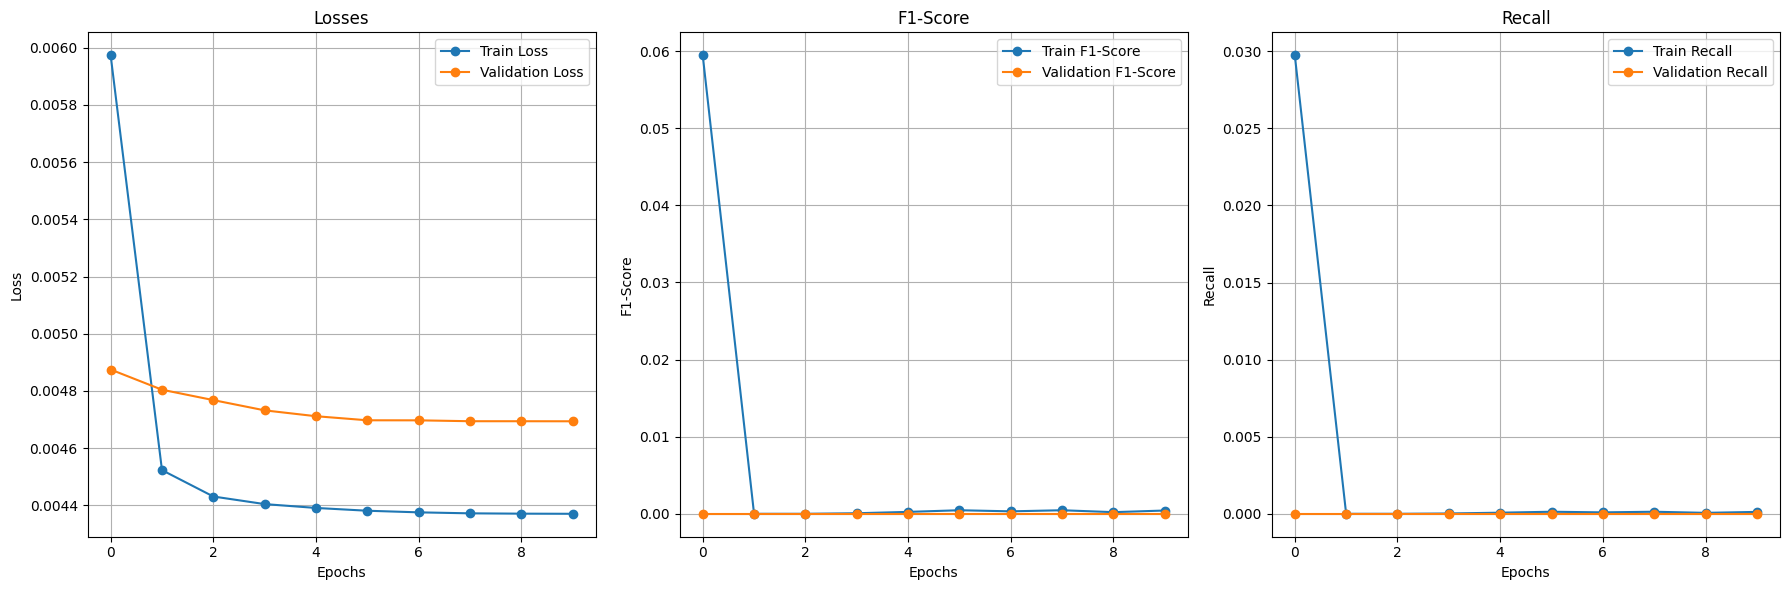

<Figure size 640x480 with 0 Axes>

In [7]:
import matplotlib.pyplot as plt

def plot_results(train_loss, val_loss, train_f1, val_f1, train_recall, val_recall):
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    # График потерь
    axs[0].plot(train_loss, label="Train Loss", marker='o')
    axs[0].plot(val_loss, label="Validation Loss", marker='o')
    axs[0].set_title("Losses")
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylabel("Loss")
    axs[0].legend()
    axs[0].grid(True)

    # График F1-Score
    axs[1].plot(train_f1, label="Train F1-Score", marker='o')
    axs[1].plot(val_f1, label="Validation F1-Score", marker='o')
    axs[1].set_title("F1-Score")
    axs[1].set_xlabel("Epochs")
    axs[1].set_ylabel("F1-Score")
    axs[1].legend()
    axs[1].grid(True)

    # График Recall
    axs[2].plot(train_recall, label="Train Recall", marker='o')
    axs[2].plot(val_recall, label="Validation Recall", marker='o')
    axs[2].set_title("Recall")
    axs[2].set_xlabel("Epochs")
    axs[2].set_ylabel("Recall")
    axs[2].legend()
    axs[2].grid(True)

    plt.tight_layout()
    plt.show()
    # Сохраняем график
    plt.savefig(f"linear_{args.version}.png")

# Вызов функции с результатами
plot_results(
    train_losses, 
    test_losses, 
    train_f1_micro,
    test_f1_micro,
    train_f1_macro,
    test_f1_macro
)


In [8]:
import pandas as pd


metrics_data = {
    "Epoch": list(range(1, len(train_losses) + 1)),
    "Train Loss": train_losses,
    "Validation Loss": test_losses,
    "Train f1_micro": train_f1_micro,
    "Validation f1_micro": test_f1_micro,
    "Train f1_macro": train_f1_macro,
    "Validation f1_macro": test_f1_macro,
}

metrics_df = pd.DataFrame(metrics_data)

metrics_csv_path = f"metrics_{args.version}.csv"
metrics_df.to_csv(metrics_csv_path, index=False)
